# [Module 2.1] 인퍼런스 스크래치

### 본 워크샵의 모든 노트북은 `conda_python3` 여기에서 작업 합니다.

이 노트북은 아래와 같은 작업을 합니다.

- 0. 개념 확인
- 1. 환경 셋업
- 2. 모델 아티펙트 다운로드 및 압축해제
- 3. 추론 함수 로컬 테스트
- 4. 로컬 엔드포인트 생성
- 5. 로컬 추론
- 6. 로컬 엔드 포인트 삭제


### 참고: 
- 세이지 메이커 개발자 가이드 --> [추론을 위한 모델 배포](https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/deploy-model.html)
- 세이지 메이커 배포에 대한 웹비나 --> [Amazon SageMaker 기반 사전 훈련된 딥러닝 모델 손쉽게 배포하기 – 김대근:: AWS Innovate 2021](https://www.youtube.com/watch?v=ZdOcrLKow3I)
- 세이지 메이커 호스팅 기본 컨셉 --> [SageMaker 호스팅 아키텍쳐](https://github.com/gonsoomoon-ml/SageMaker-Pipelines-Step-By-Step/blob/main/scratch/8.1.Deploy-Pipeline.ipynb)
- 세이지 메이커로 파이토치 사용 --> [Use PyTorch with the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)
    
---    
    

# 0. 개념 확인

![inference_container.png](img/inference_container.png)

**[소스]: 위에 "참조" 에 언급된 "세이지 메이커 배포에 대한 웹비나" 의 내용입니다.**

AWS가 관리하는 배포 컨테이너에 대해 좀 더 자세히 살펴 보겠습니다. 각 프레임워크별에 적합한 배포 컨테이너들이 사전 빌드되어 있으며, 텐서플로는 텐서플로 서빙, 파이토치는 torchserve, MXNet은 MMS, scikit learn은 Flask가 내장되어 있습니다. 이 중에서 파이토치의 경우, 기존에는 MMS가 내장되어 있었지만, 2020년 말부터 Amazon과 facebook이 공동으로 개발한 torchserve를 내장하기 시작했습니다. 

배포 컨테이너를 구동할 때에는 추론을 위한 http 요청을 받아들일 수 있는 RESTful API를 실행하는 serve 명령어가 자동으로 실행되면서 엔드포인트가 시작됩니다. 엔드포인트를 시작할 때, SageMaker는 도커 컨테이너에서 사용 가능한 외부의 모델 아티팩트, 데이터, 그리고 기타 환경 설정 정보 등을 배포 인스턴스의 /opt/ml 폴더로 로딩합니다. 
/opt/ml 폴더는 도커 컨테이너의 밖에서 접근 가능한 머신 러닝 관련 파일들의 볼륨을 의미하며, 이 경로에 대한 내용을 알고 있으면 디버깅에 도움이 됩니다.

물론, 훈련과 호스팅을 모두 지원하는 단일 도커 이미지 빌드도 가능하기 때문에 오픈 소스 도커파일을 참조해서 여러분만의 환경을 구성하는 것도 가능합니다.
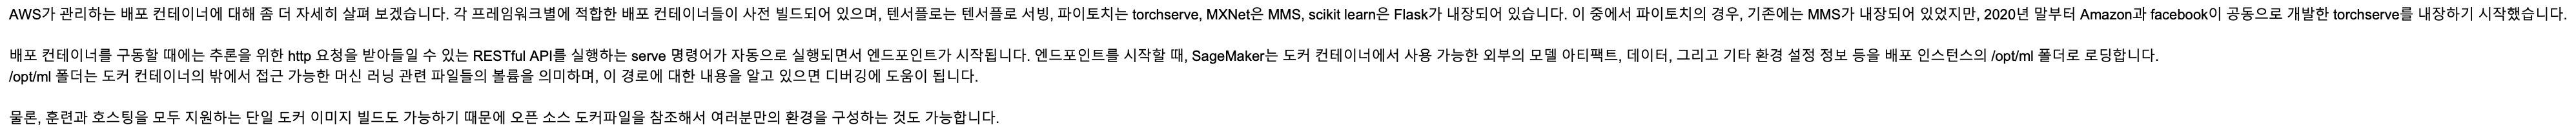

![model_artifact_structure.png](img/model_artifact_structure.png)

**[소스]: 위에 "참조" 에 언급된 "세이지 메이커 배포에 대한 웹비나" 의 내용입니다.**

우선 TensorFlow의 경우는 model 경로를 별도로 생성해 줘야 합니다. Model의 하위 폴더에는 모델 버전 번호 폴더를 생성한 다음 그 안에 훈련된 모델 파일을 넣으시면 됩니다. 이 때 주의하실 점이 하나 있는데, pb 파일은 SavedModel만 사용하셔야 하며, Frozen Graph 파일은 SavedModel로 변환해서 사용하셔야 합니다.
PyTorch, MXNet은 디렉토리 및 파일 구조가 유사합니다. 별도의 폴더를 생성하지 않고 곧바로 모델 파라메터 파일을 넣으시면 됩니다. 

그리고 code 폴더는 추론에 필요한 스크립트 파일과 requirements.txt를 포함하면 되는데, PyTorch와 MXNet은 굳이 이 폴더를 포함하지 않아도 됩니다. 텐서플로 컨테이너는 자체 모델 서빙이 아니고 TensorFlow Model Server로 전달하는 중개자 역할이기 때문에 code 폴더가 필요합니다.

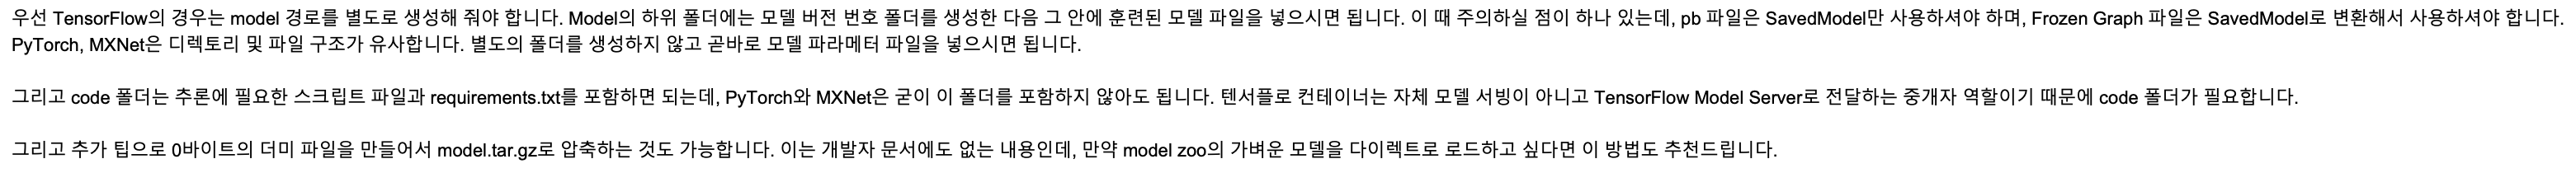

![inference_handler.png](img/inference_handler.png)

**[소스]: 위에 "참조" 에 언급된 "세이지 메이커 배포에 대한 웹비나" 의 내용입니다.**

이제, 추론에 필요한 Python 스크립트 인터페이스를 살펴 보겠습니다. 이 인터페이스들은 SageMaker Inference Toolkit이 정의한 인터페이스로, 텐서플로를 제외한 프레임워크들에서 공용으로 사용됩니다. 

model_fn() 함수는 S3나 model zoo에 저장된 모델을 추론 인스턴스의 메모리로 로드 후, 모델을 리턴하는 방법을 정의하는 전처리 함수입니다.

input_fn() 함수는 사용자로부터 입력받은 내용을 모델 추론에 적합하게 변환하는 전처리 함수로, content_type 인자값을 통해 입력값 포맷을 확인할 수 있습니다.

predict_fn() 함수는 추론 함수로, model_fn()에서 리턴받은 모델과 input_fn()에서 변환된 데이터로 추론을 수행합니다.

output_fn() 함수는 추론 결과를 반환하는 후처리 함수입니다.

그리고 input_fn(), predict_fn(), output_fn()을 각각 구현하는 대신, 세 함수들을 한꺼번에 묶어서 transform() 함수에 구현하는 것도 가능합니다. 
처음에는 익숙치 않을 수 있지만 AWS 공식 예제들이나 레퍼런스의 제 핸즈온을 한 번 해 보시면 금방 익숙해질 수 있습니다.

# 1. 환경 셋업

## 1.1. 기본 세팅
사용하는 패키지는 import 시점에 다시 재로딩 합니다.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

전 노트북에서 훈련 후의 아티펙트를 가져옵니다.

In [9]:
%store -r artifact_path
%store -r bucket
%store -r prefix

In [10]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 1.2. 배포 준비

### 1.2.1. 모델 아티펙트 확인
이 워크샵에서 제공한 노트북을 실행하셨다고 하면 아래의 모델 아티펙트가 생성이 되었을 겁니다.
artifact_path 에 해당 변수를 할당하셔서 사용하시면 됩니다.



In [11]:
print("model artifact is assigend from : ", artifact_path)

model artifact is assigend from :  s3://sagemaker-us-east-1-057716757052/pytorch-training-2023-10-28-07-43-01-333/output/model.tar.gz


### 1.2.2. 추론을 위한  데이터 세트 로딩
- 전부 데이터를 로딩할 필요가 없지만, 여기서는 기존에 사용한 함수를 이용하기 위해서 전체 데이터를 로드 합니다. 
    - 실제 데이터로 구현시에는 따로이 로드 함수를 사용하시기를 권장 합니다.


In [12]:
import data_utils 
train_data, test_data, user_num ,item_num, train_mat = data_utils.load_all(test_num=100)

In [13]:
class Params:
    def __init__(self):
        # self.epochs = 1        
        self.num_ng = 4
        self.batch_size = 256
        self.test_num_ng = 99
        self.factor_num = 32
        self.num_layers = 3
        self.dropout = 0.0
        # self.lr = 0.001
        self.top_k = 10
        self.out = True
        # self.gpu = "0"
                        
args = Params()
print("# of batch_size: ", args.batch_size)

import torch.utils.data as data

test_dataset = data_utils.NCFData(
		test_data, item_num, train_mat, 0, False)

test_loader = data.DataLoader(test_dataset,
		batch_size=args.test_num_ng+1, shuffle=False, num_workers=0)



# of batch_size:  256


# 2. 모델 아티펙트 다운로드 및 압축해제
- 모델 아티펙트를 다운로드 합니다.
- 다운로드 받은 모델 아티펙트의 압축을 해제하고 모델 가중치인 model.pth 파일을 얻습니다.

In [14]:
import os
import config

model_data_dir = config.model_path
os.makedirs(model_data_dir, exist_ok=True)
print("model_data_dir: ", model_data_dir)

model_data_dir:  ./models/


In [15]:
%%sh -s {artifact_path} {model_data_dir}

artifact_path=$1
model_data_dir=$2

echo $artifact_path
echo $model_data_dir

# 기존 데이터 삭제
rm -rf $model_data_dir/*

# 모델을 S3에서 로컬로 다운로드
aws s3 cp $artifact_path $model_data_dir

# 모델 다운로드 폴더로 이동
cd $model_data_dir

# 압축 해제
tar -xvf model.tar.gz  

s3://sagemaker-us-east-1-057716757052/pytorch-training-2023-10-28-07-43-01-333/output/model.tar.gz
./models/
download: s3://sagemaker-us-east-1-057716757052/pytorch-training-2023-10-28-07-43-01-333/output/model.tar.gz to models/model.tar.gz


tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


NeuMF-end.pth


# 3. 추론 함수 로컬 테스트


## 3.1. 추론시 사용할 모델 네트워크 설정 저장
- 모델 네트워크를 생성시에 설정값을 model_config.json 로 저장함.
- model_fn() 함수에서 모델 네트워크를 생성시에 사용 함.

In [16]:
import json
from common_utils import save_json, load_json

model_config_dict = {
    'user_num': str(user_num),
    'item_num': str(item_num),
    'factor_num' : str(args.factor_num),
    'num_layers' : str(args.num_layers),
    'dropout' : str(args.dropout),
    'model_type': config.model
}

model_config_file = 'model_config.json'
model_config_file_path = os.path.join('src', model_config_file)

save_json(model_config_file_path, model_config_dict)
# model_config_dict = load_json(model_config_file_path)    
# model_config_dict

src/model_config.json is saved


'src/model_config.json'

## 3.2. 사용자 정의 inference code

- 사용자 정의 inference 코드를 정의해서 사용하기 전에, 노트북에서 사전 테스트 및 디버깅을 하고 진행하면 빠르게 추론 개발을 할수 있습니다.


- 디폴트 inference code (input_fn, model_fn, predict_fn, output_fn) 을 사용해도 되지만, 상황에 따라서는 사용자 정의가 필요할 수 있습니다. 디폴트 코드는 아래 링크를 참고 하세요.
    - [Deploy PyTorch Models](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#deploy-pytorch-models)
    - [디폴트 inference Code](https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_pytorch_inference_handler.py)





In [17]:
from inference import model_fn , input_fn, predict_fn


In [18]:
import torch
torch.version.cuda , torch.__version__

('11.7', '2.0.1+cu117')

### 3.2.1. model_fn 테스트
- 훈련한 모델 아티펙트 파일이 정상적으로 모델에 로딩이 되는지를 확인 합니다.
- 일반적인 모델 로딩 에러
    - Torch Version(에: 1.6.0) 이 훈련시에 사용한 버전과 동일해야 합니다. 만약 다들 경우에 `RuntimeError: version_ <= kMaxSupportedFileFormatVersion INTERNAL ASSERT FAILED` 에러가 발생합니다.

In [19]:
inf_model = model_fn(config.model_path)

######## Staring model_fn() ###############
--> model_dir : ./models/
model_config_path: :  /home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/sagemaker/recommendation/Neural-Collaborative-Filtering-On-SageMaker/2_Inference/./src/model_config.json
--> model network is loaded
model_file_path: :  {model_file_path}
####### Model is loaded #########


### 3.2.2. input_fn 테스트
- 추론시의 입력을 input_fn에 전달하고 결과값이 잘 나오는지를 확인 합니다.
- 입력값의 형태에 따라서 input_fn이 변경이 필요할 수 있습니다.


추론 테스트할 1개의 레코드를 가져옵니다.

In [20]:
for user, item, label in test_loader:   
    user_np = user.detach().cpu().numpy()
    item_np = item.detach().cpu().numpy()            
    break
payload = {'user':user_np.tolist(), 'item':item_np.tolist()}
print("payload: ", payload)


payload:  {'user': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'item': [25, 1064, 174, 2791, 3373, 269, 2678, 1902, 3641, 1216, 915, 3672, 2803, 2344, 986, 3217, 2824, 2598, 464, 2340, 1952, 1855, 1353, 1547, 3487, 3293, 1541, 2414, 2728, 340, 1421, 1963, 2545, 972, 487, 3463, 2727, 1135, 3135, 128, 175, 2423, 1974, 2515, 3278, 3079, 1527, 2182, 1018, 2800, 1830, 1539, 617, 247, 3448, 1699, 1420, 2487, 198, 811, 1010, 1423, 2840, 1770, 881, 1913, 1803, 1734, 3326, 1617, 224, 3352, 1869, 1182, 1331, 336, 2517, 1721, 3512, 3656, 273, 1026, 1991, 2190, 998, 3386, 3369, 185, 2822, 864, 2854, 3067, 58, 2551, 2333, 2688, 3703, 1300, 1924, 3118]}


In [21]:
input_fn_payload = input_fn(json.dumps(payload), content_type='application/json')
print("input_fn_payload: ", input_fn_payload)

#### input_fn starting ######
content_type: application/json
#### type of input data: <class 'str'>
input_fn_payload:  [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0'), tensor([  25, 1064,  174, 2791, 3373,  269, 2678, 1902, 3641, 1216,  915, 3672,
        2803, 2344,  986, 3217, 2824, 2598,  464, 2340, 1952, 1855, 1353, 1547,
        3487, 3293, 1541, 2414, 2728,  340, 1421, 1963, 2545,  972,  487, 3463,
        2727, 1135, 3135,  128,  175, 2423, 1974, 2515, 3278, 3079, 1527, 2182,
        1018, 2800, 1830, 1539,  617,  247, 3448, 1699, 1420, 2487,  198,  811,
        1010, 1423, 2840, 1770,  881, 1913, 1803, 1734, 3326, 1617,  224, 3352,
        1869, 1182, 1331,  336, 2517, 172

### 3.2.3. predict_fn 테스트
- input_fn 의 결과값이 predict_fn으로 전달이 됩니다. 이에 대한 동작을 확인 합니다.

In [22]:
prediction = predict_fn(input_fn_payload, inf_model)
#output = predict_fn(images, model)
prediction

#### predict_fn starting ######
#### type of input data: <class 'list'>
recommends:  [128, 25, 174, 273, 464, 1902, 58, 175, 1064, 617]


[128, 25, 174, 273, 464, 1902, 58, 175, 1064, 617]

# 4. 로컬 엔드포인트 생성
- 이 과정은 로컬에 docker를 실행하고 로컬 엔드포인트를 생성합니다.



## 4.1. 추론을 위한 모델 아티펙트 

기본적인 추론의 파일 구조 입니다.
    - 참조: [PyTorch for versions 1.2 and higher](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)
    
```
model.tar.gz/
|- model.pth
|- code/
  |- inference.py
  |- requirements.txt  # only for versions 1.3.1 and higher
```

- 여기서는 model.tar.gz에 model.pth 만을 포함 합니다.
- inference.py, requirements.txt는 sagemaker.pytorch.model.PyTorchModel의 클래스 생성자에 entry_point, source_dir을 통해서 제공이 됩니다. 이와 같의 스크립트 모드 방식으로 제공이 가능합니다.
- 혹은 훈련시에 model.tar.gz에 위와 같은 폴더 구조로 모두 제공을 하여서 추론을 할 수도 있습니다.


## 4.2. Docker Debugging Tip
- Docker it 진입 명령어
    - docker exec -it 5c547b5565b6 /bin/bash
        - 참조: https://www.edureka.co/community/10588/how-can-i-run-a-docker-exec-command-inside-a-docker-container

- Docker stop container
    - `docker stop $(docker ps -a -q)`
    
    
- 노트북 인스턴스 용량 초과 에러시

```python
sh-4.2$ df -h
Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        121G   76K  121G   1% /dev
tmpfs           121G  1.1M  121G   1% /dev/shm
/dev/xvda1      104G  101G  2.3G  98% /
/dev/xvdf       985G   13G  932G   2% /home/ec2-user/SageMaker

```

- 위와 같이 df -h 를 한 후에 /dev/xvdf 용량을 확인 합니다. 위의 용량이 거의 차면 아래의 명령어를 실행하여 용량을 확보 하세요.
    - `docker container prune -f`
    - `docker image prune -f --all`    
    - `sudo rm -rf /tmp/tmp*`
    
    

- 대표적인 에러 사항
    - 훈련시에 토치버전(예: 1.6.0)이 배포시의 엔드포인트 버전과 다를 경우 (버전을 꼭 확인해주세요.)
    - 훈련시에 GPU로 훈련을 한 경우에 배포시도 GPU 엔드포인트로 해야 합니다.
    - 훈련 및 추론시에 아래와 같은 pull_image_command  에러가 존재하면 디스크 용량이 부족해서 에러가 날 수 있음. 디스크 용량을 확보한 후에 다시 실행 필요
    
```
    ~/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/local/image.py in _pull_image(image)
   1089     logger.info("docker command: %s", pull_image_command)
   1090 
-> 1091     subprocess.check_output(pull_image_command.split())
   1092     logger.info("image pulled: %s", image)
```


### 시스템의 이전 도커 컨테이너 삭제
- 아래와 같은 명령어를 사용하여 저장 공간을 확보 합니다.
- 용량 부족시 아래 주석을 제거하고 실행 하세요

In [23]:
! df -h
# ! docker container prune -f 
# ! docker image prune -f --all
# ! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs         16G     0   16G   0% /dev
tmpfs            16G   88K   16G   1% /dev/shm
tmpfs            16G  716K   16G   1% /run
tmpfs            16G     0   16G   0% /sys/fs/cgroup
/dev/nvme0n1p1  135G  103G   33G  76% /
tmpfs           3.1G     0  3.1G   0% /run/user/0
/dev/nvme2n1    985G   89G  846G  10% /home/ec2-user/SageMaker
tmpfs           3.1G     0  3.1G   0% /run/user/1002
tmpfs           3.1G     0  3.1G   0% /run/user/1000
tmpfs           3.1G     0  3.1G   0% /run/user/1001


## 4.3. 로컬 엔드포인트 생성 실행

In [24]:
import os
import time
import sagemaker
from sagemaker.pytorch.model import PyTorchModel


로컬에 있는 모델 아티펙트 경로

In [25]:
local_model_path = os.path.join(model_data_dir, 'model.tar.gz')
print("local_model_path: ", local_model_path)

local_model_path:  ./models/model.tar.gz


####  local_gpu 혹은 local 결정

In [26]:
import os
import subprocess

try:
    if subprocess.call("nvidia-smi") == 0:
        ## Set type to GPU if one is present
        instance_type = "local_gpu"
    else:
        instance_type = "local"        
except:
    pass

print("Instance type = " + instance_type)

Sat Oct 28 08:11:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   36C    P0    62W / 300W |   2146MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 세이지메이커 모델 생성 및 로컬 앤드포인트 생성

In [27]:
endpoint_name = "local-endpoint-ncf-{}".format(int(time.time()))

local_pytorch_model = PyTorchModel(model_data=local_model_path,
                                   role=role,
                                   entry_point='inference.py',
                                   source_dir = 'src',
                                   framework_version='2.0.1',
                                   py_version='py310',
                                   model_server_workers=1,
                                  )

local_predictor = local_pytorch_model.deploy(
                           instance_type=instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=endpoint_name,
                           wait=True,
                           log = False,
                        )

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Login Succeeded
Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0beaf1a020>: Failed to establish a new connection: [Errno 111] Connection refused')': /ping
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection br

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Attaching to hconmm0mwa-algo-1-qzylq
hconmm0mwa-algo-1-qzylq  | WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv
hconmm0mwa-algo-1-qzylq  | 
hconmm0mwa-algo-1-qzylq  | [notice] A new release of pip is available: 23.2.1 -> 23.3.1
hconmm0mwa-algo-1-qzylq  | [notice] To update, run: pip install --upgrade pip
hconmm0mwa-algo-1-qzylq  | ['torchserve', '--start', '--model-store', '/.sagemaker/ts/models', '--ts-config', '/etc/sagemaker-ts.properties', '--log-config', '/opt/conda/lib/python3.10/site-packages/sagemaker_pytorch_serving_container/etc/log4j2.xml', '--models', 'model=/opt/ml/model']
hconmm0mwa-algo-1-qzylq  | Warning: TorchServe is using non-default JVM parameters: -XX:-UseContainerSupport
Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Co

# 5. 로컬 추론
- 준비된 입력 데이터로 로컬 엔드포인트에서 추론

## 5.1. 프리딕터에 JSONSerializer 로 초기화
- payload 로 JSON type 으로 제공하면 JSONSerializer 가 String 으로 직렬화하여 제공 함.

In [28]:
from sagemaker.serializers import JSONSerializer
local_predictor.serializer = JSONSerializer('application/json')


## 5.2. 로컬 추론

In [29]:
local_predictor.predict(payload)
# local_predictor.predict(json.dumps(payload))

hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:46,870 [INFO ] epollEventLoopGroup-3-2 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:b808c7a9a3c2,timestamp:1698480706
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:46,872 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1698480706872
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:46,873 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1698480706
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:46,874 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - #### input_fn starting ######
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:46,874 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - content_type: application/json
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:46,874 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - #### type of input data: <class 'str'>
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:46,875 [INFO ] W-9000-model_1.0-stdout MODEL_LOG 

array([ 128,   25,  174,  273,  464, 1902,   58,  175, 1064,  617])

hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,723 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Backend response time: 2846
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,723 [INFO ] W-9000-model_1.0 TS_METRICS - WorkerThreadTime.Milliseconds:5.0|#Level:Host|#hostname:b808c7a9a3c2,timestamp:1698480709


## 5.3. Boto3 invoke_endpoint() 로 추론

In [30]:
import boto3

if instance_type == 'local_gpu':
    runtime_client = sagemaker.local.LocalSagemakerRuntimeClient()    
else:
    runtime_client = boto3.Session().client('sagemaker-runtime')


### [중요] JSON type 의 payload 를 String 으로 직렬화 해서 제공 함.
```python
payload_dump = json.dumps(payload)
```

In [31]:
import json
from inference_utils import invoke_endpoint
payload_dump = json.dumps(payload)

start_time = time.time()
result = invoke_endpoint(runtime_client, endpoint_name, 
                         payload_dump,
                         content_type='application/json'
                        )

print("--- %s seconds ---" % (time.time() - start_time))
print('result: ', result)

hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,790 [INFO ] epollEventLoopGroup-3-3 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:b808c7a9a3c2,timestamp:1698480709
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,791 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1698480709791
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,792 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1698480709
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,792 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - #### input_fn starting ######
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,792 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - content_type: application/json
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,793 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - #### type of input data: <class 'str'>
hconmm0mwa-algo-1-qzylq  | 2023-10-28T08:11:49,793 [INFO ] W-9000-model_1.0-stdout MODEL_LOG 

# 6. 로컬 엔드 포인트 삭제
- 기존에 생성한 로컬 세이지 메이커 모델, 앤드포인트 컨피그, 앤드포인트 삭제

In [33]:
from inference_utils import delete_endpoint

try:
    client = sagemaker.local.LocalSagemakerClient()
    delete_endpoint(client, endpoint_name)
except:
    pass

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
#### Start
